# Astra target landing site example

## Derivation of Nozzle lift equation (fixed ascent rate)

An estimate of the bounds of Nozzle lift is required for scipy's differential evolution algorithm. We'll use a primitive approach, since the method calculates (integrates) the ascent rate equation anyway, and a penalty method will be used for ascent rates reaching outside the desired boundaries.

Force balance:

\begin{equation}
(m_{bal} + m_{pay} + m_{gas}) \frac{d^2z}{dt^2} = B - W - D = 0\\
B = W + D\\
V(\rho_{air} - \rho_{gas}) g = (m_{bal} + m_{pay})g + \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D A
\end{equation}

Then use balloon volume to get a 3rd order polynomial in terms of $r$

\begin{equation}
\frac{4}{3} \pi (\rho_{air} - \rho_{gas}) g r^3 - \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D \pi r^2 - (m_{bal} + m_{pay})g = 0
\end{equation}

Solve for r, and extract real positive root. This root should be unique, since the cubic discriminant $18abcd - 14b^3d + b^2c^2 - 4ac^3 - 27a^2d^2$ is always less than zero for $a>0, b<0, c=0, d<0$, leading to one real and two complex conjugate roots. Then use the relation of gas mass (eqn 3 in "High-Altitude Gas Balloon Trajectory Prediction: A Monte Carlo Model") to obtain the nozzle lift:

\begin{equation}
m_{gas} = \rho^0_{gas} V^0 = \rho^0_{gas} \frac{L_N/g + m_{bal}}{\rho^0_{air} - \rho^0_{gas}}\\
L_N/g = \frac{4\pi}{3} r^3 (\rho_{air}-\rho_{gas}) - m_{bal} \hspace{1em} (kg)
\end{equation}

This is found in ```astra.flight_tools.nozzleLiftFixedAscent```, and has been validated with [habhub](http://habhub.org/calc/), which gives nozzle lift values of the same magnitude, and similar value (+- 10%)

**Note** After finding the section of habhub burst calculator that does this, it was apparent that $r$ and $m_{gas}$ is solved in the same way. See function `calc_update()` https://github.com/cuspaceflight/cusf-burst-calc/blob/master/js/calc.js

The Haversine formula is used to obtain great circle distance distance $\Delta$ of the landing site from its target (assuming a spherical Earth), as

\begin{equation}
    \Delta = 2r\dot{}\mathrm{arcsin}\left( \sqrt{\mathrm{sin^2} \left( \frac{\phi_2 - \phi_1}{2}\right) + \mathrm{cos}(\phi_1) \mathrm{cos}(\phi_2) \mathrm{sin}^2 \left(\frac{\lambda_2 - \lambda_1}{2}\right)  }\right),
\end{equation}

where $\phi, \lambda$ refer to latitude and longitude respectively, and $r$ is the Earth's average radius ($=6371km$)

## 2D Optimization: Time + Nozzle Lift

In [1]:
%load_ext autoreload
%autoreload
import astra
from astra.target_landing import targetFlight
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import interp1d
from astra.weather import forecastEnvironment
import astra
import os
from astra.GFS import GFS_Handler
%matplotlib notebook

In [19]:
GFS_Handler.weatherParameters

{'hgtprs': 'Altitude',
 'tmpprs': 'Temperature',
 'ugrdprs': 'U Winds',
 'vgrdprs': 'V Winds'}

In [5]:
# Constants
###################################################################
# Near New Arlesford, Hampshire
targetLat = 51.077214
targetLon = -1.1866875398775423
targetElev = 137                   

# launch site in Stoney Cross, Hampshire
launchSiteLat = 50.903824      # deg
launchSiteLon = -1.63697     # deg
launchSiteElev = 114.0           # m


# Set the optimisation weights used for
# [distance from target, cost, flight duration] respectively:
# Note that these are negative, because we'd like to a minimize both.
weights = (-1, -0.1, -0.)

# Use a previous forecast (allows offline development)
launch_datetime = datetime.now() + timedelta(days=1)
window = 24     # Number of hours over which to search

inputs = {}
# Use a previous forecast (allows offline development)
# simEnvironment = forecastEnvironment(launchSiteLat=launchSiteLat,
#                                      launchSiteLon=launchSiteLon,
#                                      launchSiteElev=launchSiteElev,
#                                      dateAndTime=launch_datetime,
#                                      forceNonHD=True,
#                                      debugging=True,
#                                      requestSimultaneous=False  # False has better memory overhead, but slower
#                                     )
# # # Set up the example input data files (from 22/06/2017, Daytona Beach)
# fileDict = {}
# for paramName in GFS_Handler.weatherParameters.keys():
#     fileDict[paramName] = os.path.abspath('./data/gfs_0p50_06z.ascii?{}[11:36][0:46][263:301][0:719]'.format(paramName))
# simEnvironment.loadFromNOAAFiles(fileDict)
# inputs['launchSiteForecasts'] = [simEnvironment]

simulator = targetFlight(start_dateTime=launch_datetime,
                 targetLat=targetLat,
                 targetLon=targetLon,
                 targetElev=targetElev,
                 launchSites=[(launchSiteLat, launchSiteLon, launchSiteElev)],
                 balloonModel='TA100',
                 balloonGasType="Helium",
                 nozzleLift=1,
                 trainEquivSphereDiam=0.1,
                 inflationTemperature=0.0,
                 payloadTrainWeight=0.38,
                 windowDuration=window,
                 weights=weights,
                 HD=False,
                 maxFlightTime=18000,
                 parachuteModel=None,
                 debugging=True,
                 log_to_file=False,
                 progress_to_file=False,
                 outputFile=os.path.join(''),
                 requestSimultaneous=True,
                 **inputs)



In [6]:
import copy
%autoreload
import astra

# Number of x-y points to use
Nx = 21
Ny = 21

normalizing_vector = np.array(1./simulator.cutoffDistance, 1./simulator.maxGasMass, 1./)

simulator.weights = np.array([-1, -0.1, -0.])

# This will download the forecast, if it hasn't been loaded already
bestProfile_bf, X, Y,scores = simulator.bruteForce(Nx, Ny, balloonModel='TA200')
results_bf = copy.deepcopy(simulator.results)

DEBUG:astra.weather:Fetched time zone data about the launch site: UTC offset is 1.000000 hours
DEBUG:astra.weather:Using UTC time 08/07/17 13:54
INFO:astra.weather:Preparing to download weather data for parameters:
DEBUG:astra.weather:    Launch site Latitude: 50.903824
DEBUG:astra.weather:    Launch site Longitude: -1.63697
DEBUG:astra.weather:    Launch time: 2017-07-08 13:54:51.412588
DEBUG:astra.GFS:Attempting to download cycle data.
DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170707/gfs_0p50_12z.ascii?tmpprs[8:9][0:46][271:293][0:43]
DEBUG:astra.GFS:GFS cycle not found.
DEBUG:astra.GFS:Moving to next cycle
DEBUG:astra.GFS:Attempting to download cycle data.
DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?tmpprs[10:11][0:46][271:293][0:43]
DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?tmpprs[10:11][0:46][271:293][669:71

DEBUG:astra.GFS:Requesting weather urls asynchronously: status will be sent to requests logger
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): nomads.ncep.noaa.gov
DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dod

DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?tmpprs[10:19][0:46][271:293][669:719] HTTP/1.1" 200 None
DEBUG:astra.GFS:Updating Download progress: 25.0%% complete


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?hgtprs[10:19][0:46][271:293][0:43] HTTP/1.1" 200 None
DEBUG:astra.GFS:Updating Download progress: 37.5%% complete


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?ugrdprs[10:19][0:46][271:293][0:43] HTTP/1.1" 200 None
DEBUG:astra.GFS:Updating Download progress: 50.0%% complete


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?vgrdprs[10:19][0:46][271:293][669:719] HTTP/1.1" 200 None
DEBUG:astra.GFS:Updating Download progress: 62.5%% complete


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?vgrdprs[10:19][0:46][271:293][0:43] HTTP/1.1" 200 None
DEBUG:astra.GFS:Updating Download progress: 75.0%% complete


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?hgtprs[10:19][0:46][271:293][669:719] HTTP/1.1" 200 None
DEBUG:astra.GFS:Updating Download progress: 87.5%% complete


DEBUG:requests.packages.urllib3.connectionpool:http://nomads.ncep.noaa.gov:9090 "GET /dods/gfs_0p50/gfs20170707/gfs_0p50_06z.ascii?ugrdprs[10:19][0:46][271:293][669:719] HTTP/1.1" 200 None
DEBUG:astra.GFS:Updating Download progress: 100.0%% complete


Weather downloaded.


DEBUG:astra.GFS:Forecast successfully downloaded!
DEBUG:astra.weather:GFS data successfully downloaded.
INFO:astra.target_landing:Date range: [2017-07-08 14:54:51.412588, 2017-07-09 14:54:51.412588], Nx=21 points
INFO:astra.target_landing:Nozzle Lift range: [0.42077360006931214, 1.8058625469746226] (kg), Ny=21 points
DEBUG:astra.target_landing:Running brute force calculation
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 14:54:51.412588, nozzleLift=0.42077360006931214kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 14:54:51.412588, nozzleLift=0.4347281926076209kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 14:54:51.412588, nozzleLift=0.451136347635761kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 14:54:51.412588, nozzleLift=0.4702203811300481kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 14:54:51.412588, nozzleLift=0.492245

DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 17:18:51.412588, nozzleLift=1.6163671159908624kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 17:18:51.412588, nozzleLift=1.8058625469746226kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 18:30:51.412588, nozzleLift=0.42077360006931214kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 18:30:51.412588, nozzleLift=0.4347281926076209kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 18:30:51.412588, nozzleLift=0.451136347635761kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 18:30:51.412588, nozzleLift=0.4702203811300481kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 18:30:51.412588, nozzleLift=0.49224589215684694kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 18:30:51.412588, nozzle

DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 20:54:51.412588, nozzleLift=1.8058625469746226kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 22:06:51.412588, nozzleLift=0.42077360006931214kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 22:06:51.412588, nozzleLift=0.4347281926076209kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 22:06:51.412588, nozzleLift=0.451136347635761kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 22:06:51.412588, nozzleLift=0.4702203811300481kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 22:06:51.412588, nozzleLift=0.49224589215684694kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 22:06:51.412588, nozzleLift=0.517528401121079kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 22:06:51.412588, nozzleL

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:42:51.412588, nozzleLift=0.42077360006931214kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:42:51.412588, nozzleLift=0.4347281926076209kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:42:51.412588, nozzleLift=0.451136347635761kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:42:51.412588, nozzleLift=0.4702203811300481kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:42:51.412588, nozzleLift=0.49224589215684694kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:42:51.412588, nozzleLift=0.517528401121079kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:42:51.412588, nozzleLift=0.5464413490972253kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:42:51.412588, nozzleL

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:18:51.412588, nozzleLift=0.4347281926076209kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:18:51.412588, nozzleLift=0.451136347635761kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:18:51.412588, nozzleLift=0.4702203811300481kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:18:51.412588, nozzleLift=0.49224589215684694kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:18:51.412588, nozzleLift=0.517528401121079kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:18:51.412588, nozzleLift=0.5464413490972253kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:18:51.412588, nozzleLift=0.5794256875048762kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:18:51.412588, nozzleLi

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:54:51.412588, nozzleLift=0.451136347635761kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:54:51.412588, nozzleLift=0.4702203811300481kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:54:51.412588, nozzleLift=0.49224589215684694kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:54:51.412588, nozzleLift=0.517528401121079kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:54:51.412588, nozzleLift=0.5464413490972253kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:54:51.412588, nozzleLift=0.5794256875048762kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:54:51.412588, nozzleLift=0.6170013210746006kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:54:51.412588, nozzleLi

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:30:51.412588, nozzleLift=0.4702203811300481kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:30:51.412588, nozzleLift=0.49224589215684694kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:30:51.412588, nozzleLift=0.517528401121079kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:30:51.412588, nozzleLift=0.5464413490972253kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:30:51.412588, nozzleLift=0.5794256875048762kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:30:51.412588, nozzleLift=0.6170013210746006kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:30:51.412588, nozzleLift=0.6597806995613464kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:30:51.412588, nozzleL

**To write the Pareto Front to a kml file, for viewing in google earth or mymaps:**


In [20]:
# simulator.write('myParetoFront.kml')

Check Weather Interpolators work over this range (i.e., ensure they are not constant/extrapolations)

<IPython.core.display.Javascript object>


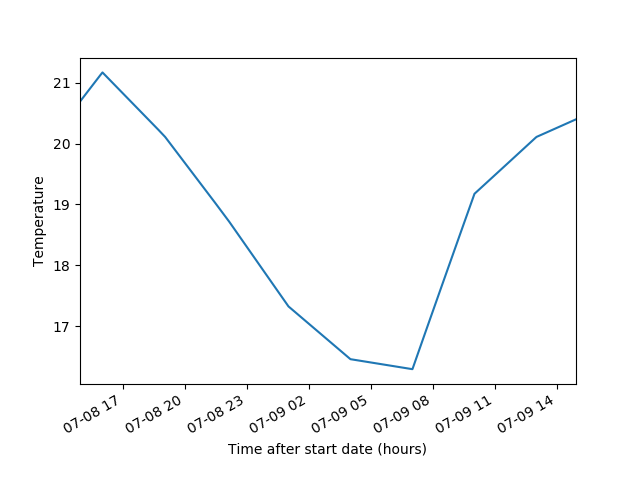

In [7]:
# Temperature visualation at the landing site, over the time window
import matplotlib.dates as mdates

simEnvironment = simulator.environment

# Plot weather as a function of time over the date range:
ts = np.linspace(0, simulator.windowDuration, 3001)
datetimes = [simEnvironment.dateAndTime + timedelta(hours=t) for t in ts]

Ps = [simEnvironment.getTemperature(simEnvironment.launchSiteLat,
                                        simEnvironment.launchSiteLon,
                                        simEnvironment.launchSiteElev, dt)
          for dt in datetimes]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(datetimes, Ps)
ax.set_ylabel("Temperature")
ax.set_xlabel("Time after start date (hours)")

xtick_locator = mdates.AutoDateLocator()
xtick_formatter = mdates.AutoDateFormatter(xtick_locator)
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.set_xlim(datetimes[0], datetimes[-1])

fig.autofmt_xdate()

21


<IPython.core.display.Javascript object>


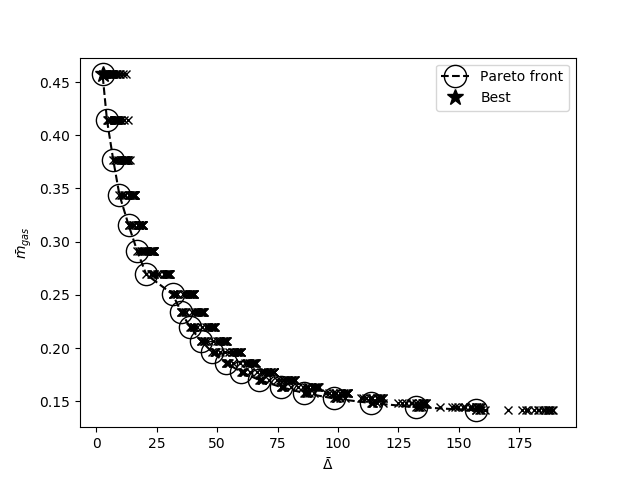

/home/pchambers/anaconda3/lib/python3.6/site-packages/deap/base.py:180: RuntimeWarning: invalid value encountered in double_scalars
  return tuple(map(truediv, self.wvalues, self.weights))


In [8]:
# simulator.results contains the lexographically sorted pareto front of the
# non dominated flights (based on weighted distance vs cost)
print(len(simulator.results))
simulator.plotParetoFront()

<IPython.core.display.Javascript object>


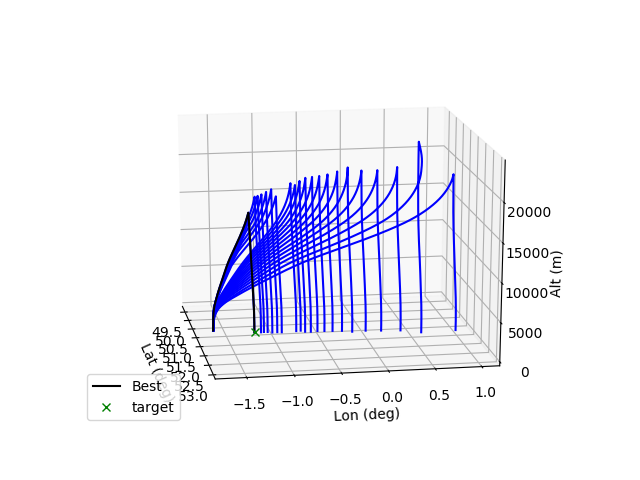

(<matplotlib.figure.Figure at 0x7fe67d8ef978>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fe67c523cc0>)

In [9]:
# Visualise the Pareto Front result paths (This may not be all that useful)
simulator.plotPaths3D()

<IPython.core.display.Javascript object>


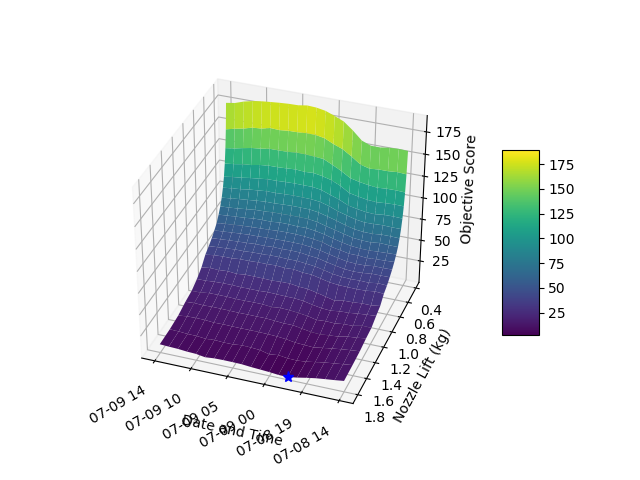

In [11]:
# Visualise the surface as a 3D surface contour:
%autoreload
from matplotlib import cm

fig1, ax1 = simulator.plotObjectiveContours3D(
    X, Y, scores.T, appendLabel=' Brute Force', cmap=cm.viridis, bestProfile=bestProfile_bf)
fig1.savefig("basic_landscape_3d.pdf")
# ax1.set_xlim([0.5, 2.25])

[ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16]


<IPython.core.display.Javascript object>


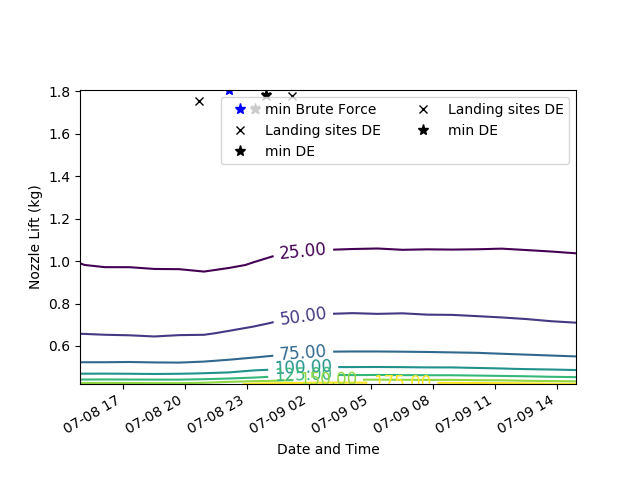

In [15]:
%autoreload
import astra

# fig3, ax3 = simulator.plotObjectiveContours(X, Y, scores.T,
#     appendLabel=' Brute Force', bestProfile=bestProfile_bf)

# To manually set the levels used in the plot, pass the levels as an additional arg:
# levels = np.linspace(0.0, 0.16, 9)
print(levels)
fig3, ax3 = simulator.plotObjectiveContours(X, Y, scores.T,
    appendLabel=' Brute Force', bestProfile=bestProfile_bf)#, levels=levels)

## Nelder Mead Simplex Algorithm

Running the code here will update the contour plot above.

In [ ]:
# %autoreload
# # Optimize with Scipy:

# res_scipy = simulator.optimizeTargetLandingSite(x0=[0.5*simulator.windowDuration, 1.0],
#                                                 options={'xtol': 1e-6, "disp": True, 'maxiter':50})
# bestProfile_scipy = simulator.bestProfile
# results_scipy = simulator.results
# Xs_scipy = simulator.Xs

In [ ]:
# Optimize with scipy differential evolution
simulator.Xs = Xs_scipy
simulator.plotObjectiveLocations(fig3, ax3, marker='rx', bestMarker='r*', 
                                   bestProfile=bestProfile_scipy, appendLabel=' Nelder-Mead')

In [ ]:
print(res_scipy)

## L-BFGS-B Algorithm

Commenting out the code here for now, as the optimization doesn't work so well...

In [ ]:
# from astra.flight_tools import nozzleLiftFixedAscent

# # Optimize with Scipy:
# start_timedelta = 0
# end_timedelta = simulator.windowDuration

# nozzleLiftLowerBound = nozzleLiftFixedAscent(simulator.minAscentRate,
#                 simulator._balloonWeight, simulator.payloadTrainWeight,
#                 simulator.environment.inflationTemperature,
#                 simulator.environment.getPressure(simulator.launchSiteLat,
#                                                   simulator.launchSiteLon,
#                                                   simulator.launchSiteElev,
#                                                   simulator.start_dateTime),
#                 simulator._gasMolecularMass, simulator.excessPressureCoeff,
#                 CD=(0.225 + 0.425)/2.)
# nozzleLiftUpperBound = nozzleLiftFixedAscent(simulator.maxAscentRate,
#                 simulator._balloonWeight, simulator.payloadTrainWeight,
#                 simulator.environment.inflationTemperature,
#                 simulator.environment.getPressure(simulator.launchSiteLat,
#                                                   simulator.launchSiteLon,
#                                                   simulator.launchSiteElev,
#                                                   simulator.start_dateTime),
#                 simulator._gasMolecularMass, simulator.excessPressureCoeff,
#                 CD=(0.225 + 0.425)/2.)

# res_lbfgsb = simulator.optimizeTargetLandingSite(x0=[0.5*simulator.windowDuration, 1.0],
#                                                  method='L-BFGS-B',
#                                                  bounds=([start_timedelta, end_timedelta],
#                                                          [nozzleLiftLowerBound, nozzleLiftUpperBound]),
#                                                  options={"disp": True, "maxfun":200},
#                                                  )
# bestProfile_lbfgsb = simulator.bestProfile
# results_lbfgsb = simulator.results
# Xs_lbfgsb = simulator.Xs

In [ ]:
# # Optimize with scipy differential evolution
# simulator.bestProfile = bestProfile_lbfgsb
# simulator.results = results_lbfgsb
# simulator.Xs = Xs_lbfgsb
# simulator.plotObjectiveLocations(fig3, ax3, marker='cx', bestMarker='c*', appendLabel=' L-BFGS-B')

In [ ]:
# print(res_lbfgsb)

## Scipy differential Evolution

In [35]:
%autoreload
import astra

res_de = simulator.optimizeTargetLandingSite(method='DE', tol=1, maxiter=6)
results_de = simulator.results
bestProfile_de = simulator.bestProfile
Xs_de = simulator.Xs

DEBUG:astra.target_landing:Arguments in the objective function are: ['t', 'targetAscentRate']
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 14:31:32.425160, nozzleLift=0.7792425550353386kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:07:43.563955, nozzleLift=0.6305763428801694kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 07:23:51.828537, nozzleLift=0.4609997764587022kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:37:06.039883, nozzleLift=0.5170022161600041kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:23:27.198357, nozzleLift=0.42565741605614066kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 17:13:53.376907, nozzleLift=0.5553678619170752kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:56:54.985231, nozzleLift=0.8350954250606151kg, balloon T

DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=0.42077360006931214kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024627, nozzleLift=0.42077360006931214kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=0.42077360063785724kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=1.019556650385923kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024627, nozzleLift=1.019556650385923kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=1.0195566545321375kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=1.2696335356500128kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024627, nozzle

DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024627, nozzleLift=1.7197615332748393kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=1.7197615417652938kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=1.7197615332748393kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024627, nozzleLift=1.7197615332748393kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=1.7197615417652938kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleLift=1.7197615332748393kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024627, nozzleLift=1.7197615332748393kg, balloon TA200
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 23:24:20.024591, nozzleL

In [36]:
res_de

     fun: 3.2478994996713011
     jac: array([   0.        ,  535.16794578])
 message: 'Optimization terminated successfully.'
    nfev: 159
     nit: 1
 success: True
       x: array([ 8.49128111,  5.90170458])

In [37]:
simulator.Xs = Xs_de
simulator.plotObjectiveLocations(fig3, ax3, marker='kx',
                                 bestMarker='k*', appendLabel=' DE',
                                 bestProfile=bestProfile_de)

(<matplotlib.figure.Figure at 0x7fe67409e358>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe67409e2e8>)

In [38]:
fig3.savefig('Distance2D_NozzleLift_LaunchTime.pdf')

In [ ]:
print("Brute Force: delta={} km, nevals={}".format(bestProfile_bf.distanceFromTarget, Nx * Ny))
print("Differential Evolution: delta={} km, nevals={}".format(bestProfile_de.distanceFromTarget, res_de.nfev))
print("Nelder Mead: delta={} km, nevals={}".format(bestProfile_scipy.distanceFromTarget, res_scipy.nfev))

## Higher Dimensional Problem

### Slice with cutdown altitude

In [39]:
import copy
%autoreload

# Number of x-y points to use
Nx = 3
Ny = 3

# 
bestProfile_slicing, X, Y, Z, scores = simulator.bruteForceSlice(Nx, Ny, balloonModel='TA200',
                                                                    flightMode='cutdown',
                                                                    sliceParam='deviceActivationAltitude', 
                                                                    Nslices=5, sliceBounds=(1e4, 2.2e4))
results_slicing = copy.deepcopy(simulator.results)


DEBUG:astra.target_landing:Arguments in the objective function are: ['t', 'targetAscentRate', 'deviceActivationAltitude']
INFO:astra.target_landing:Date range: [2017-07-08 14:54:51.412588, 2017-07-09 14:54:51.412588], Nx=3 points
INFO:astra.target_landing:Nozzle Lift range: [0.42077360006931214, 1.8058625469746226] (kg), Ny=3 points
INFO:astra.target_landing:deviceActivationAltitude range: [10000.0, 22000.0] m, Nz=5 points]
DEBUG:astra.target_landing:Running brute force calculation
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 14:54:51.412588, nozzleLift=0.42077360006931214kg, balloon TA200, cutdown Altitude 10000.0m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 14:54:51.412588, nozzleLift=0.42077360006931214kg, balloon TA200, cutdown Altitude 13000.0m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 14:54:51.412588, nozzleLift=0.42077360006931214kg, balloon TA200, cutdown Altitude 16000.0m
DEBUG:astra.target_landing:Running flig

<IPython.core.display.Javascript object>


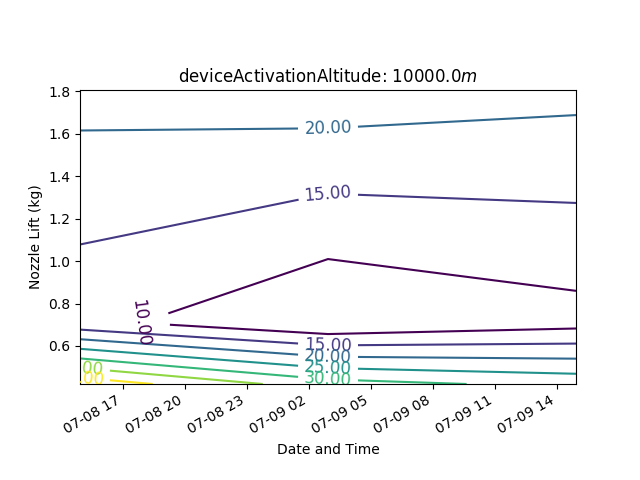

<IPython.core.display.Javascript object>


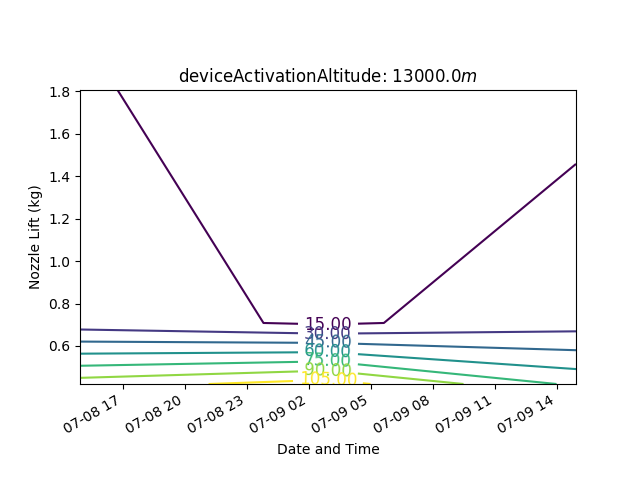

<IPython.core.display.Javascript object>


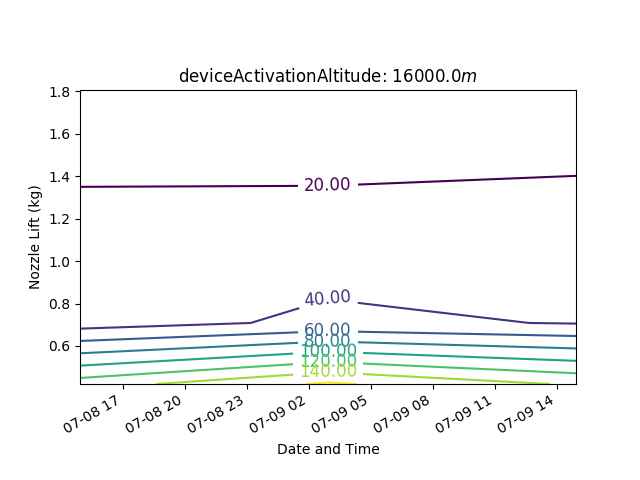

<IPython.core.display.Javascript object>


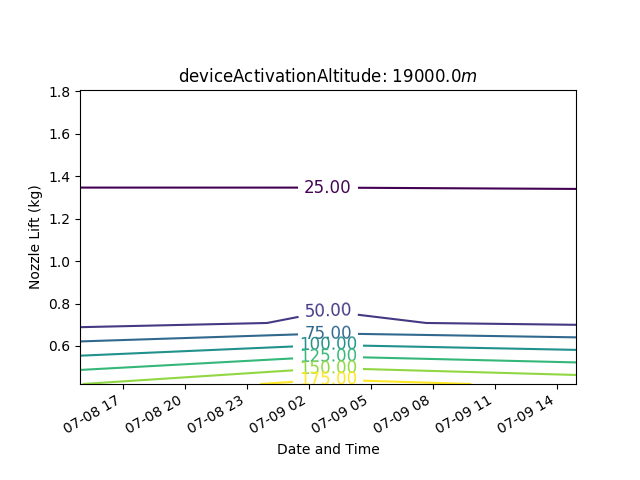

<IPython.core.display.Javascript object>


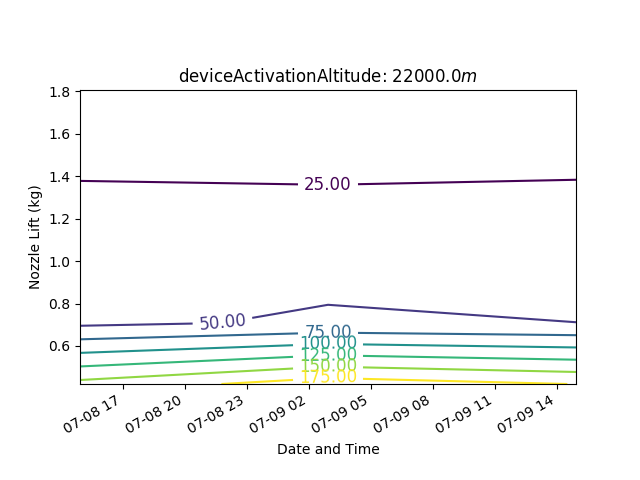

In [40]:
for i, z in enumerate(Z):
    scores_slice = scores[:, :, i]
#     levels = np.arange(0, 90, 10)
    fig, ax = simulator.plotObjectiveContours(X, Y, scores_slice.T,
        appendLabel=' Brute Force')
    ax.set_title(r"{}: ${}m$".format(simulator.variables[-1], z))
    fig.savefig('{}_{}_contour.pdf'.format(simulator.variables[-1], z))

<IPython.core.display.Javascript object>


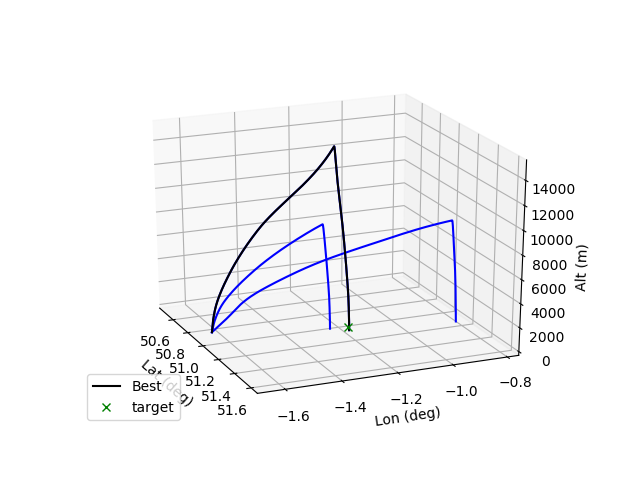

(<matplotlib.figure.Figure at 0x7fe6537a0e10>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fe66c183470>)

In [41]:
simulator.plotPaths3D()

### Other slicing parameters

Uncomment the following slice cases as necessary, to view the objective landscape sliced through different parameters:

In [ ]:
%autoreload

# Number of x-y points to use
Nx = 3
Ny = 3

# This will slice through balloon models
# bestProfile_slicing, X, Y, Z, scores = simulator.bruteForceSlice(Nx, Ny, balloonModel='TA200',
#                                                                     flightMode='standard',
#                                                                     sliceParam='balloonNominalBurstDia', 
#                                                                     Nslices=5, sliceParam_subset=['TA100', 'TA200', 'HW800'])

# # This will slice through floating flight with floating altitude for a fixed floatDuration
# bestProfile_slicing, X, Y, Z, scores = simulator.bruteForceSlice(Nx, Ny, balloonModel='TA200',
#                                                                     flightMode='floating',
#                                                                     sliceParam='deviceActivationAltitude',
#                                                                     floatDuration=300,  #seconds
#                                                                     Nslices=5, sliceBounds=(12e3, 20e3))
# for i, z in enumerate(Z):
#     scores_slice = scores[:, :, i]
# #     levels = np.arange(0, 90, 10)
#     fig, ax = simulator.plotObjectiveContours(X, Y, scores_slice.T,
#         appendLabel=' Brute Force')
#     ax.set_title(r"{}: ${}m$".format(simulator.variables[-1], z))
#     fig.savefig('{}_{}_contour.pdf'.format(simulator.variables[-1], z))

In [ ]:
# simulator.plotPaths3D()

## Optimization in higher dimensions

We consider the following multi-objective optimization problem, where $\Delta$ is the ground distance from the landing site, $m_{gas}$ is the gass mass required to achieve input target ascent rate $\bar{\frac{dz}{dt}}$ (relating to cost), and $t$ is the flight duration (included to reduce the cold soak time of the payload) obtained for an input vector $\bf{x}$,

\begin{equation}
\min_{\textbf{x} \in \mathbb{R}}(f(\textbf{x})) \\
f(\mathbf{x}) = w_1 \cdot \Delta(\textbf{x}) + w_2 \cdot m_{gas}(\textbf{x}) + w3 \cdot t(\textbf{x}) + p_0(\textbf{x})\\
p_0 = \begin{cases} 
    5 \times 10^6 & \text{if not landed} \\
    0 & \text{otherwise}
   \end{cases}\\
\textbf{x} = [t, \bar{\frac{dz}{dt}}, i_f, z_{d}, t_{float}, D_{burst}]
\end{equation}

subject to the bounds, 

\begin{equation}
t \in [0, 72] \mathrm{hours}\\
\bar{\frac{dz}{dt}} \in [1.5, 6] \mathrm{m/s}\\
i_f \in [0, 2] \\
z_d \in [z_{0}, z_{1}]\\
t_{float} \in [0, t_{max}]\\
D_\mathrm{burst} \in [D_\mathrm{burst,min}, D_\mathrm{burst,max}].
\end{equation}

Altitude control mechanisms for the flight are contained with the flight mode parameter, $i_f$, i.e., flight mode 0 corresponds to standard ascent-burst-descent flight, mode 1 forces a cutdown burst at device activation altitiude $z_d$, and mode 2 vents the lifting gas uniformly after a given altitude to reach a floating segment at $z_d$, before being forced to burst after $t_{float}$ seconds. $D_{burst}$ is the nominal burst diameter, used as a dummy variable for odering and selecting the nearest neighbour of a subset of chosen 'available' balloons, with burst diameters ranging from $D_\mathrm{burst,min}$ to $D_\mathrm{burst,max}$. Weightings $\textbf{w} = [w_1, w_2, w_3]$ should be used to scale and normalise the importance of each metric; normalizing metrics for these parameters, respectively, could be obtained from the maximum possible distance travelled (e.g., assuming a flight entirely in the jet stream with a maximum speed of $200m/s$), a maximum gas mass required to achieve the upper bound of ascent rate given the largest selected balloon, and a maximum cutoff flight time $t_{max}$. Currently $z_{0}, z_{1}$ are user inputs for 'sensible' values of floating or cutdown flight altitude for a given mission, taking into account the nominal balloon burst altitude, local regulations and air traffic; however, this may be eligible for automated calculation in future. The penalty function, $p_0$ is imposed if the balloon did not burst within the allowable flight duration. Although it is not implemented here, a quadratic penalty function (or similar) may be of interest for maintaining ascent rates within the desired bounds.

Differential evolution was the most robust in the previous example, independant of the initial (conversely to Nelder-Mead), so we'll use it here.

**Notes**
* `cutdown` does not have to be activated ($i_c = 1$) for floating flight to begin decent after flight duration $t_c$.

In [44]:
%autoreload

simulator.weights = (-1, -0.1, -0.5)

res_de_HD = simulator.optimizeTargetLandingSite(method='DE', flightModes=['standard', 'floating', 'cutdown'],
                                             deviceActivationAltitudeBounds=(8e3, 30e3),
                                             flexibleBalloon=True,
                                             balloonModels=['TA100', 'TA200', 'HW200', 'HW800'],
                                             tol=1, maxiter=5, seed=62)
results_de_HD = simulator.results
bestProfile_de_HD = results_de_HD[0]
Xs_de_HD = simulator.Xs

DEBUG:astra.target_landing:Arguments in the objective function are: ['t', 'targetAscentRate', 'flightMode', 'deviceActivationAltitude', 'floatDuration', 'balloonNominalBurstDia']
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 14:36:33.305686, nozzleLift=1.8353784961707154kg, balloon HW800, Floating Altitude 24386.725108198694m, Duration 9230.861644788634 seconds
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 06:07:32.335606, nozzleLift=0.6575454744810358kg, balloon HW800
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:23:49.717121, nozzleLift=1.392994694327041kg, balloon TA200, Floating Altitude 18343.131341593606m, Duration 11706.555136293247 seconds
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 09:14:49.919794, nozzleLift=1.0888044243059452kg, balloon TA100, Floating Altitude 20707.928020727602m, Duration 5589.227152456069 seconds
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 16:15:08.2

DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 22:59:59.783313, nozzleLift=0.47155779335976805kg, balloon TA200, cutdown Altitude 13846.056658363545m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 14:15:42.029377, nozzleLift=1.3730651086090837kg, balloon HW800, cutdown Altitude 11148.268572555786m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:56:29.380116, nozzleLift=0.9319308606630428kg, balloon HW800, Floating Altitude 13374.919285836146m, Duration 17227.687035990723 seconds
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 05:16:57.464849, nozzleLift=1.011270020945993kg, balloon HW800, cutdown Altitude 27625.023252831023m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 13:15:56.077624, nozzleLift=0.6608175117324653kg, balloon TA200, Floating Altitude 23292.52829397426m, Duration 13064.584247389845 seconds
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 20:18:13.862928, no

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 08:39:15.730174, nozzleLift=1.5674864869310055kg, balloon TA100, cutdown Altitude 10082.122772617728m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:17:15.543122, nozzleLift=1.09022700382958kg, balloon TA200, cutdown Altitude 23333.219958305326m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 01:35:23.512636, nozzleLift=1.759633387371643kg, balloon HW800, Floating Altitude 22190.552744100594m, Duration 15174.649115599586 seconds
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:30:24.379607, nozzleLift=1.1454897141042786kg, balloon TA100
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 21:11:41.853230, nozzleLift=0.6443604584732936kg, balloon HW800, cutdown Altitude 17892.570160857438m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 11:09:23.985557, nozzleLift=0.7386944841027181kg, balloon TA200, cutdown Altitude 10734.619081399

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 12:54:08.870678, nozzleLift=0.600184252898851kg, balloon HW800, cutdown Altitude 29482.50934115479m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 06:38:17.376726, nozzleLift=2.23642442905843kg, balloon HW800, Floating Altitude 28538.264398469066m, Duration 15745.917942366512 seconds
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 02:35:55.586209, nozzleLift=1.3966279493098717kg, balloon TA200, Floating Altitude 28745.532133372788m, Duration 2152.037945971324 seconds
DEBUG:astra.target_landing:Running flight for datetime 2017-07-08 21:16:33.017628, nozzleLift=1.342043765505036kg, balloon TA200, cutdown Altitude 15034.21566413662m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 06:25:38.756372, nozzleLift=0.4573006071574209kg, balloon TA200, cutdown Altitude 9403.986476486816m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 09:42:01.714023, nozzleLif

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=0.4448383897272883kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=0.44483838883167404kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=0.44483838883167404kg, balloon HW800, cutdown Altitude 8860.255947051135m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=0.44483838883167404kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=0.44483838883167404kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.2220115652990087kg, balloon HW800, cutdown Altitude 8860.25594704

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.230409217128388kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.230409217128388kg, balloon HW800, cutdown Altitude 8860.255947051135m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.230409217128388kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.230409217128388kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.230359676032073kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956460, nozzleLift=2.230359676032073kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBU

DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.2302213929252845kg, balloon HW800, cutdown Altitude 8860.255947051135m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.2302213929252845kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.2302213929252845kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.230287869209328kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956460, nozzleLift=2.230287869209328kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.2302878796868377kg, balloon HW800, cutdown Altitude 8860.255947041134m


DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.2302214144959907kg, balloon HW800, cutdown Altitude 8860.255947041134m
DEBUG:astra.target_landing:Running flight for datetime 2017-07-09 03:37:18.956424, nozzleLift=2.2302214144959907kg, balloon HW800, cutdown Altitude 8860.255947041134m


The Pareto front of this domain is independent of the weighting vector, and is visualised as below:

<IPython.core.display.Javascript object>


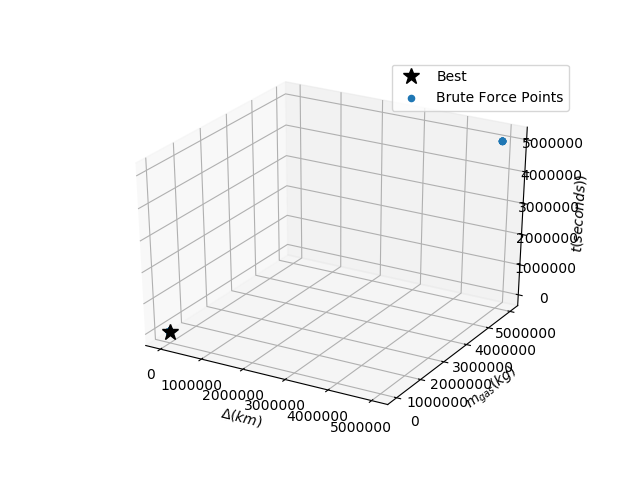

In [46]:
simulator.plotParetoFront()

# Output the members of the Pareto front with the lowest distance metric
results_temp = copy.deepcopy(simulator.results)
simulator.results = sorted(simulator.results, key=lambda result: result.fitness.values[0])[0:10]

simulator.write('BestDistance.kml')

In [ ]:
print(len(simulator.results))

In [ ]:
res_de_HD

In [ ]:
simulator.plotPaths3D()

## Genetic Algorithm (DEAP)

Experimental genetic algorithm optimisation code, from the python `DEAP` library. All parameters are converted to normalised floating point values, bounded between 0 and 1, which are then used to interpolate an input value between the bounds of the parameters as described previously. The $\mu+\lambda$ evolution strategy then uses NSGA-ii selection, Gaussian mutation, and a `blending' crossover method. We set a population size of 50, and approximate the number of generations required to maintain a number of evaluations of 1500, roughly on par with that expected for the Differential Evolution scipy implementation to reach the specified convergence criteria.

In [ ]:
%autoreload
simulator.weights = (-1, -0.1, -0.5)

res_de_HD = simulator.optimizeTargetLandingSite(method='GA', flightModes=['standard', 'floating', 'cutdown'],
                                             deviceActivationAltitudeBounds=(8e3, 30e3),
                                             flexibleBalloon=True,
                                             balloonModels=['TA100', 'TA200', 'HW200', 'HW800'],
                                             tol=1, maxiter=5, seed=62)
results_de_HD = simulator.results
bestProfile_de_HD = results_de_HD[0]
Xs_de_HD = simulator.Xs

In [ ]:
resultsresults_de_HD

## Testing

Random elements of code to go here....